# The Best Times to Post to reddit Revisited

A few weeks ago Redditor [/u/Stuck_In_the_Matrix](https://www.reddit.com/user/Stuck_In_the_Matrix) released the [full corpus of reddit submissions](https://www.reddit.com/r/datasets/comments/3mg812/full_reddit_submission_corpus_now_available_2006/) from January 2006 to August 31, 2015. Just a few days later [/u/fhoffa](https://www.reddit.com/user/fhoffa) made it [available via Google Big Query](https://www.reddit.com/r/bigquery/comments/3mv82i/dataset_reddits_full_post_history_shared_on/).

Max Wolf [wrote a tutorial](http://minimaxir.com/2015/10/reddit-bigquery/) on how to analyze this dataset providing some interesting examples, one of them looking at the best time to post to reddit, considering only submissions that reached a score of 3000 or higher. Felipe also [took a stab at this](https://www.reddit.com/r/dataisbeautiful/comments/3nkwwa/the_best_time_to_post_to_reddit_east_coast_early/) broken down by subreddits.

Both charts indicate, that the time of submission is a big factor for success. Max' chart doesn't take differences between subreddits into account and Felipe's chart doesn't account for the influence of weekdays though. So let's break down the time of submission by weekday and hour for several subreddits. Please note that in contrast to Max and Felipe I look at posts with 1000 or more points from all years and use Coordinated Universal Time (UTC) instead of Eastern Standard Time (EST).

## Biqguery

I ran the following query to get the data via Google's BigQuery interface.

    SELECT subreddit, dayofweek, hourofday, num_with_min_score, total
    FROM (
      SELECT
        DAYOFWEEK(created_utc) as dayofweek,
        HOUR(created_utc) as hourofday,
        SUM(score >= 1000) as num_with_min_score,
        SUM(num_with_min_score) OVER(PARTITION BY subreddit) total,
        subreddit,
      FROM [fh-bigquery:reddit_posts.full_corpus_201509]
      GROUP BY subreddit, dayofweek, hourofday
      ORDER BY subreddit, dayofweek, hourofday
    )
    WHERE total>100
    ORDER BY total DESC, dayofweek, hourofday

This returns the number of posts that reached more than 1000 points broken down by subreddit, weekday and hour of the day, for all subreddits that have at least 100 submissions with more than 1000 points. Since the resulting dataset was too large to download directly, I had to create a table from it first and export it to a Google cloud storage bucket, before I could download it to my computer.

## Setup

Load the necessary libraries, set some global display variables, read the downloaded CSV file into a [pandas DataFrame](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) and show the first few lines.

In [1]:
%matplotlib inline
%load_ext signature

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import helpers

# Set style and meta info.
mpl.style.use('ramiro')
mpl.rcParams['axes.grid'] = False

# DAYOFWEEK returns the day of the week as an integer between 1 (Sunday) and 7 (Saturday).
weekdays_short = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
chartinfo = 'Author: Ramiro Gómez - ramiro.org • Data: /u/Stuck_In_the_Matrix & /u/fhoffa - reddit.com'
infosize = 12

df = pd.read_csv('data/reddit/reddit-top-posts-by-subreddit-weekday-hour.csv')
df.head()

,subreddit,dayofweek,hourofday,num_with_min_score,total
0,funny,1,0,909,139737
1,funny,1,1,898,139737
2,funny,1,2,841,139737
3,funny,1,3,736,139737
4,funny,1,4,568,139737


## Plotting function

To avoid repeating code, I put the plot creation into the function below. If called with a subreddit it filters the data accordingly, then groups by weekday and hour. This grouped data is then unstacked to yield the data structure needed for the call to [imshow](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow). The remaining code is for setting annotations, labels, ticks and the color legend.

In [2]:
def plot_post_times(subreddit=None):
    df_plot = df.copy()
    title = 'Number of reddit submissions that reached ≥1000 points by time of submission'
    footer = 'Accounts for {:,d} submissions to subreddits with >100 submissions that reached at least 1000 points from January 2006 to August 31, 2015.\n'.format(df.num_with_min_score.sum())
    
    if subreddit:
        df_plot = df[df.subreddit.str.lower() == subreddit.lower()]
        title = 'Number of submissions to /r/{} that reached ≥ 1000 points by time of submission'.format(subreddit)
        footer = 'Accounts for {:,d} submissions to /r/{} that reached at least 1000 points from the subreddit\'s start to August 31, 2015.\n'.format(int(df_plot[0:1].total), subreddit)
    
    grouped = df_plot.groupby(['dayofweek', 'hourofday'])['num_with_min_score'].sum()
    if grouped.empty:
        print('Empty series after grouping.')
        return
    
    image = grouped.unstack()

    fig, ax = plt.subplots(figsize=(14, 5))
    cmap = plt.cm.Greens
    img = ax.imshow(image, cmap=cmap, interpolation='nearest')
    
    # Annotations, labels, and axes ticks.
    ax.set_title(title, y=1.08, fontsize=16)
    ax.annotate(footer + chartinfo, xy=(0, -.35), xycoords='axes fraction', fontsize=infosize)
    ax.set_xlabel('Hour of reddit submission (UTC)', fontsize=infosize)
    ax.set_ylabel('Weekday of reddit submission', fontsize=infosize)
    plt.xticks(range(24))
    plt.yticks(range(7), weekdays_short)

    # Draw color legend.
    values = grouped.values
    bins = np.linspace(values.min(), values.max(), 5)
    plt.colorbar(img, shrink=.6, ticks=bins)

    plt.savefig('img/' + helpers.slug(title), bbox_inches='tight')

## All subreddits with at least 100 submissions that reached 1000 points

The first plot below shows the submission times for all records in the dataset. Remember from the query above that only subreddits with more than 100 submissions, that reached at least 1000 points, are taken into account.

Summarized over all subreddits in the dataset the day of the week doesn't matter that much, but the hour of submission makes a big difference. If you account for the time offset and my color scale going to a darker green, this chart is very similar to the one created Max.

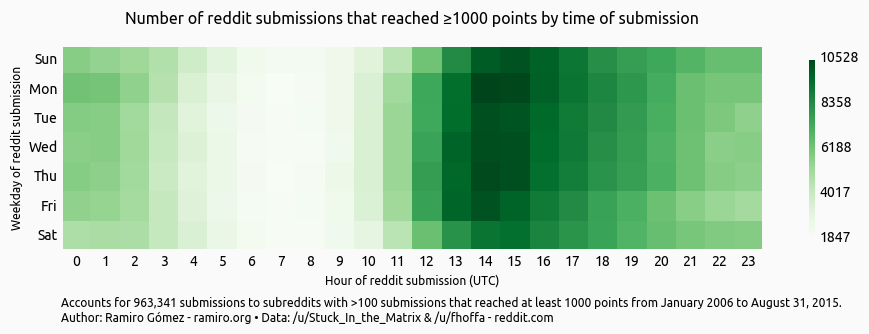

In [3]:
plot_post_times()

## Selected subreddits

As Felipe's graphic shows the subreddit does matter too, so let's look at a selection of subreddits, that happen to be some of my favorites.

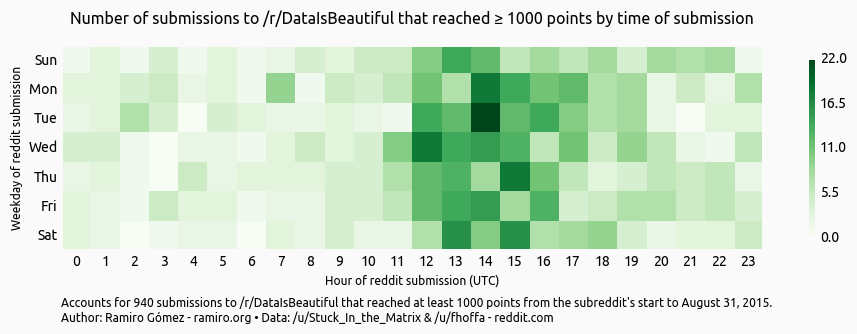

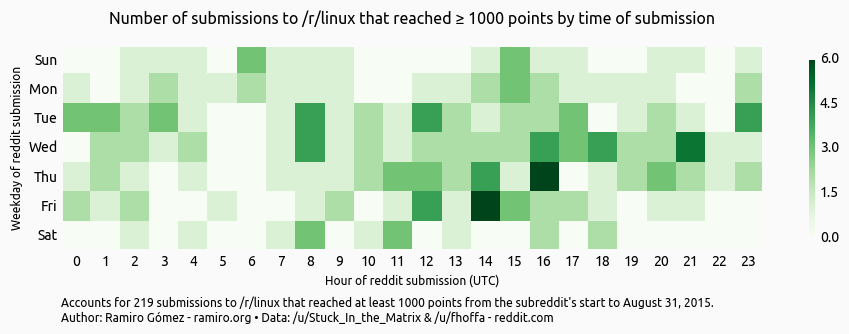

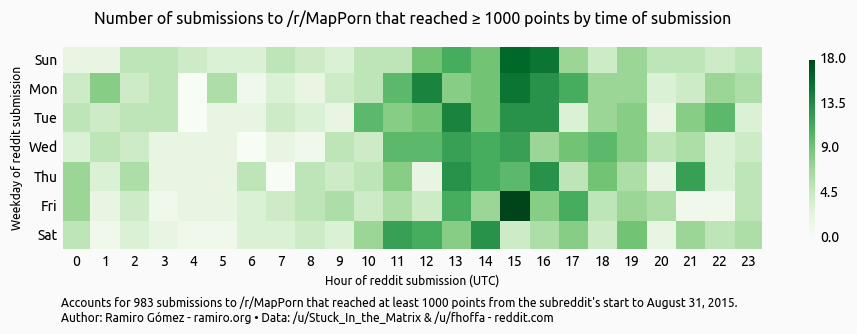

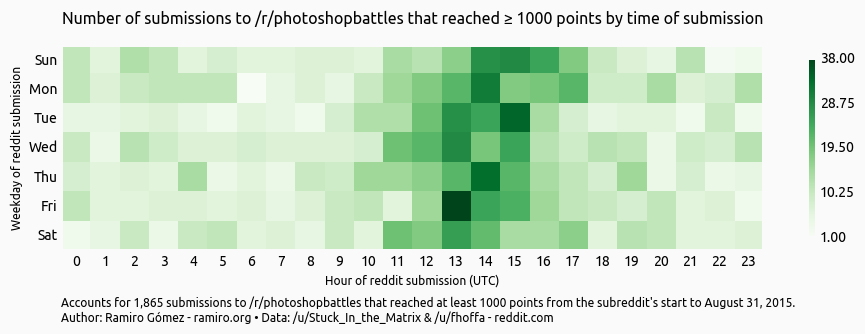

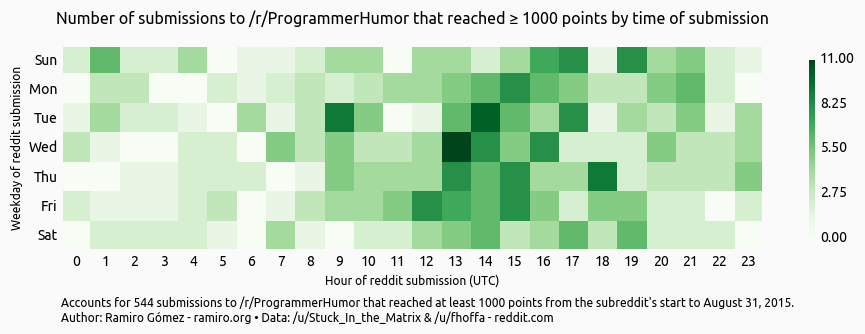

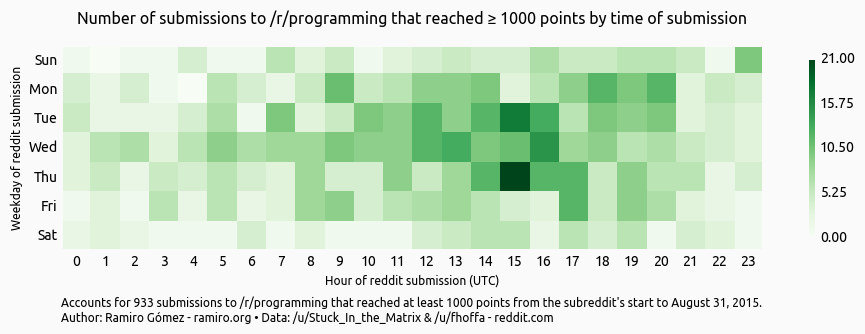

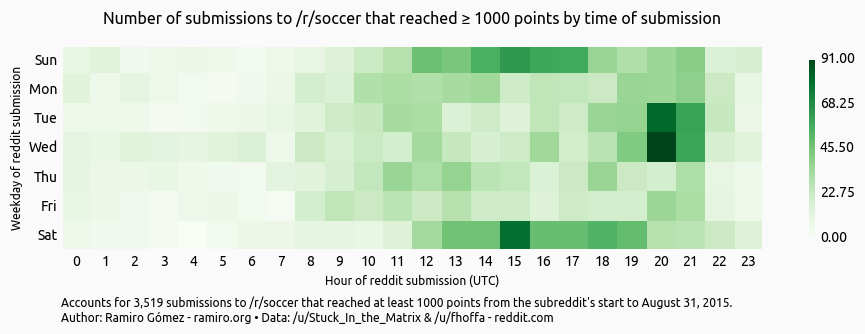

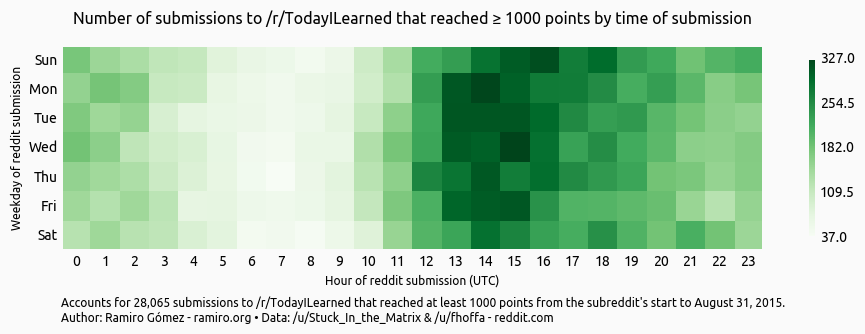

In [4]:
for sub in ['DataIsBeautiful', 'linux', 'MapPorn', 'photoshopbattles', 'ProgrammerHumor', 'programming', 'soccer', 'TodayILearned']:
    plot_post_times(sub)

These plots confirm that the subreddit can make a big difference, but there are some other interesting patterns visible.

TodayILearned has by far the most submissions, that reached 1000 points, from the set above and it is most similar to the chart created from the complete dataset. The distributions we see in smaller subreddits are more diffuse and differ more from the overall picture. This makes sense, because the bigger a subreddit gets, the closer it resembles the overall population of reddit.

One chart that stands out is that of the soccer subreddit. When games take place in the top European leagues (Saturday and Sunday in the afternoon) and in the Champions League (Tuesday and Wednesday in the evening), you have the best chance to submit a high-scoring post.

## Summary

The plots created in this notebook confirm that time of submission to reddit is a big factor for success, but they also show that these times can vary considerably across subreddits. Obviously, other factors than time play a role as well and merely posting at the "best" time for a particular subreddit won't guarantee a high score. On the other hand a quality submission posted at a bad time may not get the attention it deserves.

## Update

I've created an [interactive tool to explore post times](http://ramiro.org/tool/reddit-post-times/) for hundreds of subreddits based on the reddit posts corpus. Have fun exploring!

In [5]:
%signature